In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import rnn

In [2]:
class SeriesPredictor:
    def __init__(self, input_dim, seq_size, hidden_dim):
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim

        # Weight variables and input placeholders
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])

        # Cost optimizer
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(self.cost)

        # Auxiliary ops
        self.saver = tf.train.Saver()

    def model(self):
        """
        :param x: inputs of size [T, batch_size, input_size]
        :param W: matrix of fully-connected output layer weights
        :param b: vector of fully-connected output layer biases
        """
        cell = rnn.BasicLSTMCell(self.hidden_dim)
        outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        num_examples = tf.shape(self.x)[0]
        print('Shape '+str(np.shape(self.x))) # this turns out to be [3, 4, 1] - 3 samples of size 4 in a matrix
        print('Num Ex: '+str(np.shape(self.x)[0])) # this is 3 for self.x
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1]) # creates repeated array of [10, 1, 1] * [3, 1, 1] - our "memory" of what we picked for each hidden dim in the 3 states
        out = tf.matmul(outputs, W_repeated) + self.b_out # [batch_size, max_time, cell.output_size] so [3, 3, 10] * [30, 1, 1] + [3]
        out = tf.squeeze(out) # removes all size 1 dimensions, so takes us down from 
        return out

    
    def train(self, train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(self.cost, feed_dict={self.x: test_x, self.y: test_y})
                    print('step: {}\t\ttrain err: {}\t\ttest err: {}'.format(step, train_err, test_err))
                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1
            save_path = self.saver.save(sess, 'ch10-model2.ckpt')
            print('Model saved to {}'.format(save_path))

    def test(self, sess, test_x):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, './ch10-model2.ckpt')
        output = sess.run(self.model(), feed_dict={self.x: test_x})
        return output


In [3]:
def load_series(filename, series_idx=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=';') # Loops through the lines of the file and converts to a floating-point number
            next(csvreader) # skip the header
            data = [float(row[series_idx]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
            return normalized_data
    except IOError:
        return None

In [4]:
def split_data(data, percent_train=0.80):
    num_rows = len(data) * percent_train
    return data[:int(num_rows)], data[int(num_rows):]

In [5]:
def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Shape (?, 5, 1)
Num Ex: ?
Instructions for updating:
Use tf.cast instead.


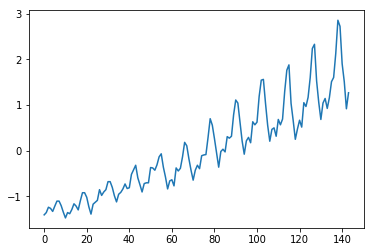

In [6]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim=100)
data = load_series('international-airline-passengers.csv')
plt.figure()
plt.plot(data)
plt.show()

step: 0		train err: 0.9801545143127441		test err: 2.1832497119903564
step: 100		train err: 0.041242677718400955		test err: 0.25669941306114197
step: 200		train err: 0.03950931131839752		test err: 0.27091410756111145
step: 300		train err: 0.03700752183794975		test err: 0.2409295290708542
step: 400		train err: 0.03543940931558609		test err: 0.3476009666919708
step: 500		train err: 0.03424490615725517		test err: 0.3287810683250427
step: 600		train err: 0.032842427492141724		test err: 0.26890209317207336
Model saved to ch10-model2.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ch10-model2.ckpt
Shape (?, 5, 1)
Num Ex: ?
predicted_vals (23,)
INFO:tensorflow:Restoring parameters from ./ch10-model2.ckpt
Shape (?, 5, 1)
Num Ex: ?
INFO:tensorflow:Restoring parameters from ./ch10-model2.ckpt
Shape (?, 5, 1)
Num Ex: ?
INFO:tensorflow:Restoring parameters from ./ch10-model2.ckpt
Shape (?, 5, 1)
Num Ex: ?
INFO:t

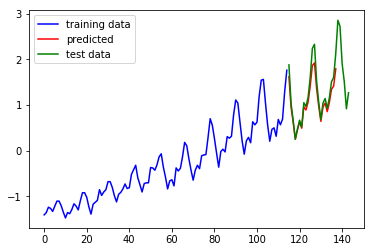

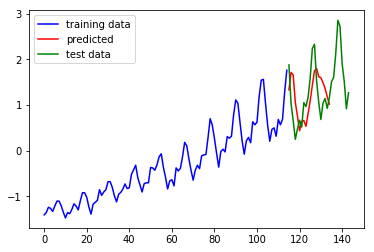

In [7]:
train_data, actual_vals = split_data(data)

train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

predictor.train(train_x, train_y, test_x, test_y)

with tf.Session() as sess:
    predicted_vals = predictor.test(sess, test_x)[:,0]
    print('predicted_vals', np.shape(predicted_vals))
    plot_results(train_data, predicted_vals, actual_vals, 'predictions.png')

    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(20):
        next_seq = predictor.test(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))
    plot_results(train_data, predicted_vals, actual_vals, 'hallucinations.png')